In [260]:
import numpy as np
from numpy.linalg import norm

from scipy.fftpack import dct as _dct
from scipy.fftpack import idct as _idct

from scipy.ndimage import correlate1d, gaussian_filter1d
from scipy.interpolate import CubicSpline

import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from numba import vectorize

from astropy.convolution import Gaussian2DKernel, Gaussian1DKernel, interpolate_replace_nans, convolve, convolve_fft

%matplotlib inline

np.set_printoptions(linewidth=150)

def load_matrix(fname, encoding='utf8', delimiter=','):
    _data = np.genfromtxt(fname, dtype=np.float64, skip_header=0, delimiter=delimiter, filling_values=None,
                          autostrip=True, encoding=encoding)
    data = _data[1:, 1:]
    times, wavelengths = _data[1:, 0], _data[0, 1:]
    return data, times, wavelengths


def save_mat2csv(fname, matrix, times=None, wls=None, unit='', delimiter=','):
    """Saves matrix with 6 significat digits."""
    times = np.arange(0, matrix.shape[0]) if times is None else times
    wls = np.arange(0, matrix.shape[1]) if wls is None else wls

    mat = np.hstack((times[:, None], matrix))
    buffer = f'unit: {unit} - Time | Wavelength->'
    buffer += delimiter + delimiter.join(f"{num}" for num in wls) + '\n'
    buffer += '\n'.join(delimiter.join(f"{num:.6g}" for num in row) for row in mat)

    with open(fname, 'w', encoding='utf8') as f:
        f.write(buffer)


def plot_data(D, times, wavelengths, symlog=False, title='', t_unit='ps',
              z_unit='$10^3\ \Delta A$', cmap='hot', z_lim=(None, None),
              t_lim=(None, None), w_lim=(None, None), fig_size=(6, 4), dpi=500, filepath=None, transparent=True,
              linthresh=10, linscale=1, D_mul_factor=1e3, y_major_formatter=ScalarFormatter(), x_minor_locator=None):
    """data is individual dataset"""

    plt.rcParams['figure.figsize'] = fig_size
    # plt.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95, wspace=0.23, hspace=0.26)

    # times = data.times
    # wavelengths = data.wavelengths
    # D = data.D * D_mul_factor

    # cut data if necessary

    t_lim = (times[0] if t_lim[0] is None else t_lim[0], times[-1] if t_lim[1] is None else t_lim[1])
    w_lim = (wavelengths[0] if w_lim[0] is None else w_lim[0], wavelengths[-1] if w_lim[1] is None else w_lim[1])

    zmin = np.min(D) if z_lim[0] is None else z_lim[0]
    zmax = np.max(D) if z_lim[1] is None else z_lim[1]

    x, y = np.meshgrid(wavelengths, times)  # needed for pcolormesh to correctly scale the image

    # plot data matrix D

    plt.pcolormesh(x, y, D, cmap=cmap, vmin=zmin, vmax=zmax)

    plt.colorbar(label=z_unit)
    plt.title(title)
    plt.ylabel(f'$\leftarrow$ Time delay / {t_unit}')
    plt.xlabel(r'Wavelength / nm $\rightarrow$')

    plt.ylim(t_lim)
    plt.xlim(w_lim)

    plt.gca().invert_yaxis()
    
    if symlog:
        plt.yscale('symlog', subs=[2, 3, 4, 5, 6, 7, 8, 9], linscale=linscale, linthresh=linthresh)
        yaxis = plt.gca().yaxis
        yaxis.set_minor_locator(MinorSymLogLocator(linthresh))
        
    if y_major_formatter:
        plt.gca().yaxis.set_major_formatter(y_major_formatter)
        
    plt.gca().tick_params(which='major', direction='in')
    plt.gca().tick_params(which='minor', direction='in')
    
    if x_minor_locator:
        plt.gca().xaxis.set_minor_locator(x_minor_locator)

    plt.tight_layout()

    # save to file
    if filepath:
        ext = os.path.splitext(filepath)[1].lower()[1:]
        plt.savefig(fname=filepath, format=ext, transparent=transparent, dpi=dpi)

    plt.show()

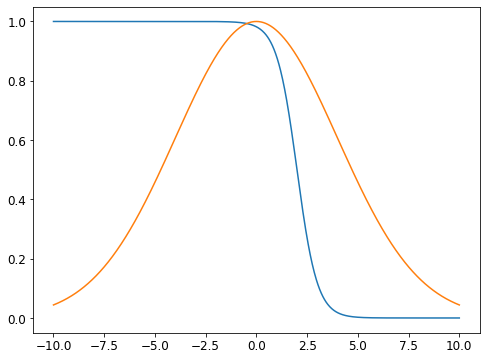

In [375]:
@vectorize
def logistic(x, mean, std):
    if std > 0:
        return 1 / (1 + np.exp(2 * (x - 2 * std - mean) / std))
    else:
        return 0

def gauss(x, mean, std):
    return np.exp(-0.5 * ((x - mean) / (std * 4)) ** 2)
    
x = np.linspace(-10, 10, 1000)
y = logistic(x, 0, 1)
yg = gauss(x, 0, 1)
plt.plot(x, y)
plt.plot(x, yg)
plt.show()

In [323]:
# from https://stackoverflow.com/questions/40104377/issiue-with-implementation-of-2d-discrete-cosine-transform-in-python

def dct(block):
    return _dct(block, norm='ortho')

def idct(block):
    return _idct(block, norm='ortho')

def dct2(block):
    """
    Computes 2D discrete cosine transform. 
    """
    return _dct(_dct(block.T, norm='ortho').T, norm='ortho')


def idct2(block):
    """
    Computes 2D inverse discrete cosine transform. 
    """
    return _idct(_idct(block.T, norm='ortho').T, norm='ortho')

def baseline_2D_arPLS(Y, lam0=1e5, lam1=1e2, niter=10, tol: float = 2e-3, lam0_sm=20, lam1_sm=0):
    N = Y.shape[0]
    K = Y.shape[1]
    
    W = np.ones_like(Y)  # weight matrix
    
    # Gamma = - 2 * np.cos(np.arange(N)[:, None] * np.pi / N) - 2 * np.cos(np.arange(K)[None, :] * np.pi / K)
    
    l0 = 2 * (1 - np.cos(np.arange(N) * np.pi / N))  # eigenvalues of diff matrix for 1st dimension
    l1 = 2 * (1 - np.cos(np.arange(K) * np.pi / K))  # eigenvalues of diff matrix for 2nd dimension
    
    gamma = 1 / (1 + (np.sqrt(lam0) * l0[:, None] + np.sqrt(lam1) * l1[None, :]) ** 2)
    gamma_smooth = 1 / (1 + (np.sqrt(lam0_sm) * l0[:, None] + np.sqrt(lam1_sm) * l1[None, :]) ** 2)
    
    Z = Y  # intialize the baseline
    D = None
    
    crit = 1
    i = 0
    # tdiff, wdiff = times[1] - times[0], wls[1] - wls[0]
    
    Z = idct2(gamma * dct2(Z))  # calculate the baseline
    
    smoothed_signal = idct2(gamma_smooth * dct2(Y))  
    diff = Y - smoothed_signal  # for noise estimation
    
    sigma0, sigma1 = 10, 0.1
    
    # kernel = Gaussian2DKernel(sigma1, sigma0)
    # std_blur = np.sqrt(convolve_fft(diff ** 2, kernel))
    
    s = np.std(diff)
    print(s)

    while i < niter:  # crit > tol
        D = Y - Z  # data corrected for baseline
#         Dn = D[D < 0]  # negative data values
#         Dn_matrix = D.copy()
#         Dn_matrix[Dn_matrix >= 0] = np.nan
        
#         sigma0, sigma1 = 0.3, 5

#         kernel = Gaussian2DKernel(sigma1 / wdiff, sigma0 / tdiff)
#         Dn_matrix_blured = convolve_fft(Dn_matrix, kernel)
#         std_matrix = (Dn_matrix - Dn_matrix_blured) ** 2
#         std_matrix_blured = np.sqrt(convolve_fft(std_matrix, kernel))
#         std_matrix_blured[std_matrix_blured < 0] = 0
        
        new_W = gauss(D, 0, s)
        # new_W = logistic(D, 0, std_blur)

        Z = idct2(gamma * dct2(W * (Y - Z) + Z))  # calculate the baseline

        crit = norm(new_W - W) / norm(W)
        W = new_W

        # if (i + 1) % int(np.sqrt(niter)) == 0:
        print(f'Iteration={i + 1}, {crit=:.2g}')
        i += 1

    return Z, D, W, smoothed_signal, std_blur


#  from 10.1016/j.csda.2009.09.020
def smooth2D(Y, lam0=1e5, lam1=1e2):
    N = Y.shape[0]
    K = Y.shape[1]

    l0 = 1 + lam0 * (-2 + 2 * np.cos(np.arange(N) * np.pi / N)) ** 2
    l1 = 1 + lam1 * (-2 + 2 * np.cos(np.arange(K) * np.pi / K)) ** 2

    basis = l0[:, None] * l1[None, :]

    smooth = idct2(dct2(Y) / basis)
    return smooth


    
def baseline_naive(y, lam=1e4):
    L = len(y)

    diag = np.ones(L - 2)
    D = sparse.spdiags([diag, -2*diag, diag], [0, -1, -2], L, L - 2)

    H = lam * D.dot(D.T)
    
    I = sparse.eye(L)
    z = linalg.spsolve(I + H, y)
    
    return z, y - z

def baseline_AsLS(y, lam=1e4, p=0.1, niter=10):
    L = len(y)

    diag = np.ones(L - 2)
    D = sparse.spdiags([diag, -2*diag, diag], [0, -1, -2], L, L - 2)

    H = lam * D.dot(D.T)
    
    W = sparse.eye(L)
    
    for i in range(niter):
        z = linalg.spsolve(W + H, W * y)
        d = y - z
        
        w = np.where(d > 0, p, 1-p)

        W.setdiag(w)

    return z, d
    
def spectra_model(x):
    coeff = np.array([100, 200, 100, 50])
    mean = np.array([300, 750, 800, 450])

    stdv = np.array([30, 30, 15, 30])

    terms = []
    for ind in range(len(coeff)):
        term = coeff[ind] * np.exp(-((x - mean[ind]) / stdv[ind])**2)
        terms.append(term)

    spectra = sum(terms)

    return spectra

x_vals = np.arange(1, 1001)
spectra_sim = spectra_model(x_vals)

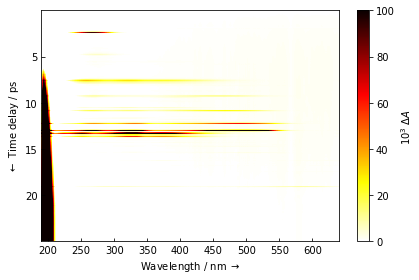

In [294]:
# mat, times, wls = load_matrix('UV_DMbr061, after extraction.csv')
mat, times, wls = load_matrix('UV_DMbp002b.csv')

plot_data(mat, times, wls, cmap='hot_r', z_lim=(0, 1e2))

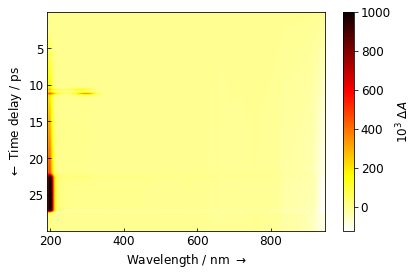

In [371]:
# apply 2D gaussian filter

sigma0, sigma1 = 0.1, 5
tdiff, wdiff = times[1] - times[0], wls[1] - wls[0]

kernel = Gaussian2DKernel(sigma1 / wdiff, sigma0 / tdiff)
filtered = convolve_fft(mat, kernel)

# , interpolate_replace_nans

# filtered = gaussian_filter1d(gaussian_filter1d(mat, sigma0, axis=0), sigma1, axis=1)

plot_data(filtered, times, wls, cmap='hot_r', z_lim=(None, 1e3))

In [324]:
Z, D, W, smoothed_signal, std_blur = baseline_2D_arPLS(mat, 1e8, 0, niter=30, lam0_sm=1e3, lam1_sm=0)



2.1127089491638418
Iteration=1, crit=0.29
Iteration=2, crit=5.3e-16
Iteration=3, crit=0.066
Iteration=4, crit=0.041
Iteration=5, crit=0.045
Iteration=6, crit=0.045
Iteration=7, crit=0.039
Iteration=8, crit=0.031
Iteration=9, crit=0.024
Iteration=10, crit=0.018
Iteration=11, crit=0.015
Iteration=12, crit=0.013
Iteration=13, crit=0.013
Iteration=14, crit=0.012
Iteration=15, crit=0.012
Iteration=16, crit=0.011
Iteration=17, crit=0.0089
Iteration=18, crit=0.0063
Iteration=19, crit=0.0042
Iteration=20, crit=0.0031
Iteration=21, crit=0.0027
Iteration=22, crit=0.0024
Iteration=23, crit=0.0023
Iteration=24, crit=0.0022
Iteration=25, crit=0.0021
Iteration=26, crit=0.002
Iteration=27, crit=0.002
Iteration=28, crit=0.0019
Iteration=29, crit=0.0019
Iteration=30, crit=0.0018


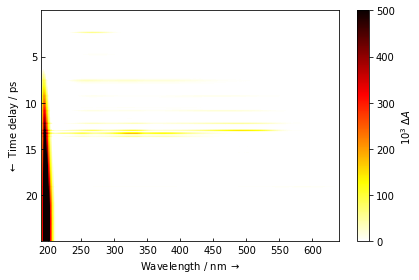

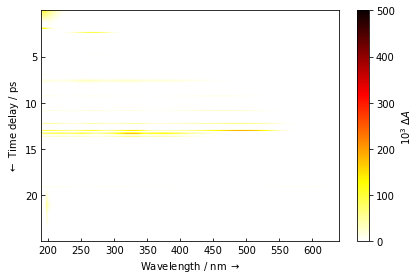

In [325]:
plot_data(smoothed_signal, times, wls, cmap='hot_r', z_lim=(0, 500))
plot_data(D, times, wls, cmap='hot_r', z_lim=(0, 500))

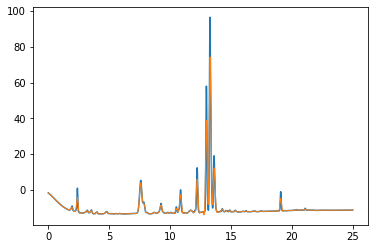

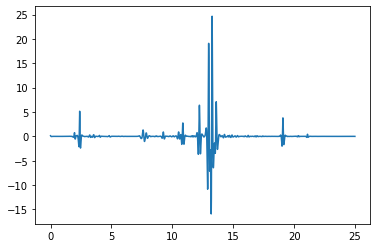

In [326]:
wi = 40

plt.plot(times, mat[:, wi], )
plt.plot(times, smoothed_signal[:, wi], lw=1)

plt.show()

plt.plot(times, mat[:, wi] - smoothed_signal[:, wi], )
plt.show()

In [328]:
save_mat2csv('test_mat.csv', D, times, wls)
save_mat2csv('test_mat-baseline.csv', Z, times, wls)

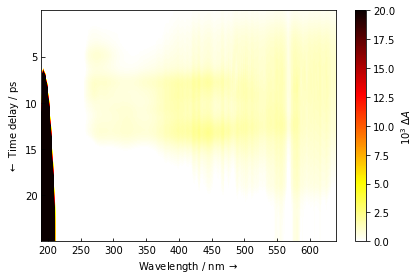

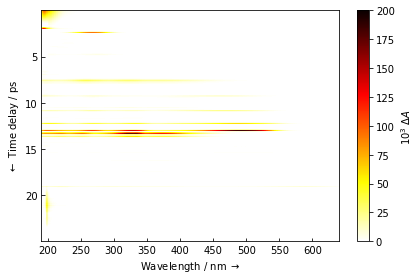

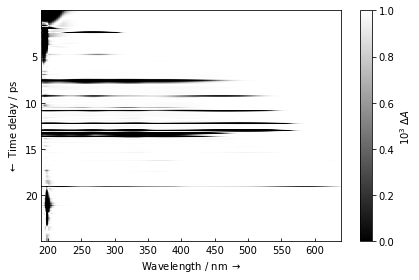

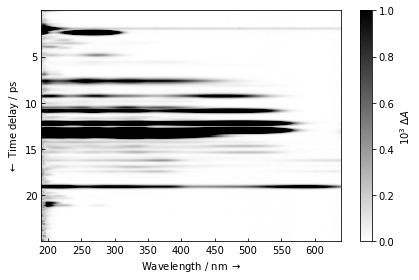

In [327]:
plot_data(Z, times, wls, cmap='hot_r', z_lim=(0, 20))
plot_data(D, times, wls, cmap='hot_r', z_lim=(0, 200))
plot_data(W, times, wls, cmap='binary_r', z_lim=(0, None))
plot_data(std_blur, times, wls, cmap='binary', z_lim=(0, 1))

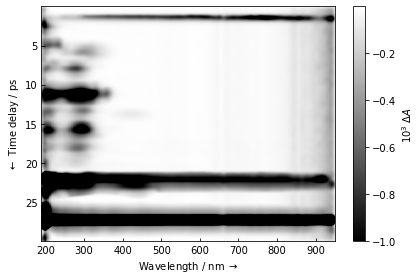

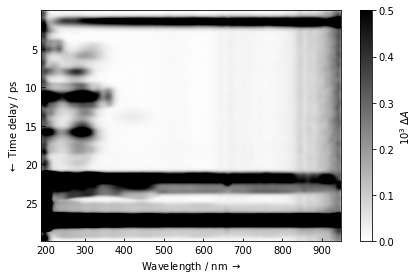

In [79]:
# Apply 2D gaussian blur to negative data

sigma0, sigma1 = 0.3, 5

kernel = Gaussian2DKernel(sigma1 / wdiff, sigma0 / tdiff)
Dn_matrix_blured = convolve_fft(Dn_matrix, kernel)
std_matrix = (Dn_matrix - Dn_matrix_blured) ** 2
std_matrix_blured = np.sqrt(convolve_fft(std_matrix, kernel))
std_matrix_blured[std_matrix_blured < 0] = 0

plot_data(Dn_matrix_blured, times, wls, cmap='binary_r', z_lim=(-1, np.nanmax(Dn_matrix_blured)))
plot_data(std_matrix_blured, times, wls, cmap='binary', z_lim=(0, 0.5))

In [71]:
(std_matrix_blured > 0).sum()

array([[0.03288581, 0.0343448 , 0.03552455, ..., 0.0211991 , 0.01983808, 0.01843348],
       [0.03382054, 0.0353262 , 0.03654503, ..., 0.02173308, 0.02033265, 0.01888823],
       [0.03476497, 0.03631782, 0.03757618, ..., 0.02227353, 0.02083303, 0.01934817],
       ...,
       [0.25718165, 0.27602956, 0.29339232, ..., 0.024287  , 0.0229592 , 0.02154371],
       [0.25336737, 0.27191206, 0.28899241, ..., 0.02395134, 0.02264882, 0.02125897],
       [0.2495122 , 0.26775198, 0.28454854, ..., 0.02361293, 0.02233563, 0.02097136]])

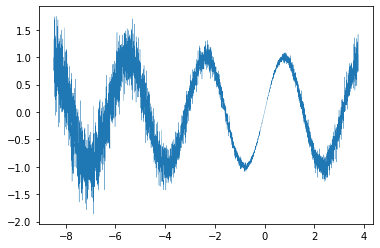

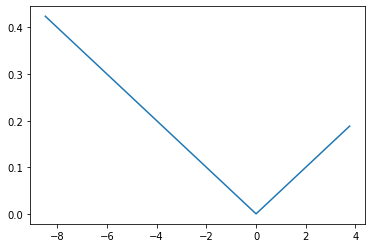

In [153]:
x = np.linspace(-2.7*np.pi, 1.2*np.pi, 5000)
x_abs = np.abs(x) * 0.05

y = np.sin(2*x)

y = np.random.normal(y, x_abs)

plt.plot(x, y, lw=0.3)
plt.show()
plt.plot(x, x_abs)
plt.show()

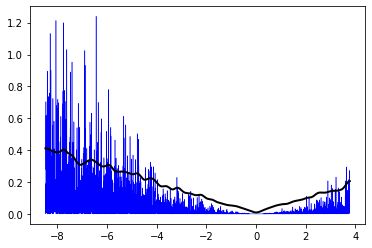

In [160]:
s = 50

y_gb = gaussian_filter1d(y, s, mode='wrap')

diff = (y - y_gb) ** 2
diff_gb = np.sqrt(gaussian_filter1d(diff, s, mode='reflect'))

# plt.plot(x, y, lw=0.3, c='k')
# plt.plot(x, y_gb, lw=2, c='r')
# plt.plot(x, diff, lw=0.3, c='r')

plt.plot(x, diff, lw=0.5, c='b')
plt.plot(x, diff_gb, lw=2, c='k')

plt.show()

In [222]:
def get_penalties(y, y_smooth):
    
    grad_y = np.gradient(np.gradient(y_smooth))
    
    return np.sum((y - y_smooth) ** 2) / y.shape[0], np.sum(grad_y ** 2) * y.shape[0] ** 3

penalties = np.asarray([get_penalties(y, smooth) for smooth, y in zip(smootheds, ys)])

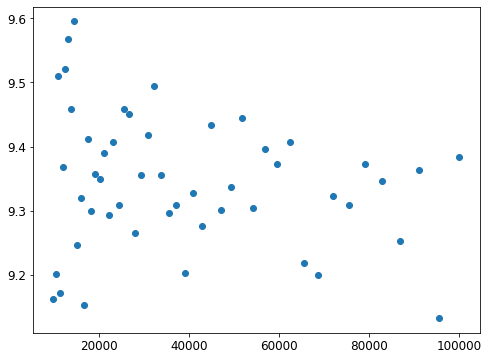

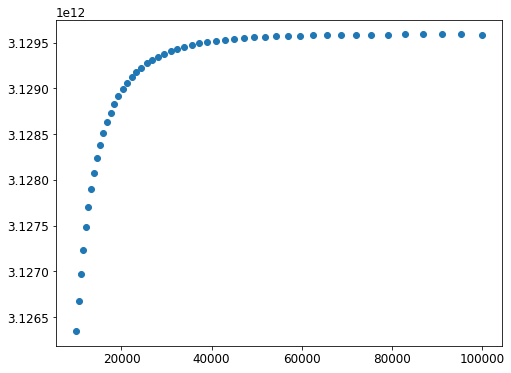

In [223]:
plt.scatter(n_vals, penalties[:, 0])
plt.show()

plt.scatter(n_vals, penalties[:, 1])
plt.show()

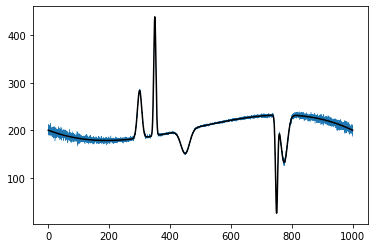

(10000,)

In [336]:
from scipy.interpolate import CubicSpline

def spectra_model(x):
    coeff = np.array([100, -200, -100, -50, 250])
    mean = np.array([300, 750, 775, 450, 350])

    stdv = np.array([10, 5, 15, 20, 5])

    terms = []
    for ind in range(len(coeff)):
        term = coeff[ind] * np.exp(-((x - mean[ind]) / stdv[ind])**2)
        terms.append(term)

    spectra = sum(terms)

    return spectra

def gen_data(ns):
    
    smootheds = []
    ys = []
    xs = []
    
    for n in ns:
        x_vals = np.linspace(0, 1000, int(n))
        spectra_sim = spectra_model(x_vals)

        noise_magnitude = 2e-5 * (x_vals - 500) ** 2 + 1

        x_poly = np.array([0, 250, 700, 1000])
        y_poly = np.array([200, 180, 230, 200])
        tdiff = x_vals[1] - x_vals[0]

        poly = CubicSpline(x_poly, y_poly)
        baseline = poly(x_vals)

        smoothed = spectra_sim + baseline
        spectra_base = np.random.normal(smoothed, noise_magnitude)  # add a noise
        
        ys.append(spectra_base)
        smootheds.append(smoothed)
        xs.append(x_vals)
    return smootheds, ys, xs

n_vals = np.logspace(3, 4, 2)
smootheds, ys, xs = gen_data(n_vals)

plt.plot(xs[-1], ys[-1], lw=0.4)
plt.plot(xs[-1], smootheds[-1], 'k')

# plt.plot(x_vals, baseline, c='r')
plt.show()


spectra_base = ys[-1]
smoothed = smootheds[-1]
x_vals = xs[-1]

spectra_base.shape

In [354]:
def baseline_1D_arPLS(y, lam=1e5, niter=10, tol: float = 2e-4, smooth_lam=10):
    N = y.shape[0]
    w = np.ones_like(y)  # weight matrix
    
    l0 = 2 * (1 - np.cos(np.arange(N) * np.pi / N))  # eigenvalues of diff matrix for 1st dimension
    # tdiff = x_dim[1] - x_dim[0]
    # tdiff2 = tdiff * tdiff
    
    # print(N ** 4)
    
    gamma = 1 / (1 + (lam * N ** 4) * l0 ** 2)
    gamma_smooth = 1 / (1 + (smooth_lam * N ** 4) * l0 ** 2)
    
    d = None
    
    crit = 1
    i = 0
    
    zs = []
    ws = []
    dn_vec = []
    std_vec = []
    
    z = idct(gamma * dct(y))  # initial estimate of baseline, just a smoothing
    smoothed_signal = idct(gamma_smooth * dct(y))  # initial estimate of baseline, just a smoothing
    diff = y - smoothed_signal  # for noise estimation
    
    sigma0, sigma1 = 5, 0
    
    kernel = Gaussian1DKernel(sigma0)
    std_blur = np.sqrt(convolve_fft(diff ** 2, kernel))

    p = 0.01
    
    while i < niter:  # crit > tol
        d = y - z  # data corrected for baseline
        
        # m = np.mean(diff)
        # s = np.std(diff)

        # new_w = 1 / (1 + np.exp(2 * (d - (2 * std_matrix_blured - Dn_matrix_blured)) / std_matrix_blured))
        # new_w = logistic(d, 0, std_blur)  # update weights with logistic function, arPLS
        new_w  = gauss(d, 0, std_blur)
        # new_w = np.where(y >= z, 1 / (1 + np.exp(2 * (d - (2 * s - m)) / s)), 1)  # update weights with logistic function, arPLS
        
        # new_w = np.where(y > z, p, 1 - p)  # AsLS
        # new_w = np.where(y >= z, 0, np.exp(-d / m))  # airPLS

        crit = norm(new_w - w) / norm(w)
        w = new_w
        
        z = idct(gamma * dct(w * (y - z) + z))  # calculate the baseline

        if (i + 1) % int(np.sqrt(niter)) == 0:
            # print(f'Iteration={i + 1}, {crit=:.2g}, {m=}, {s=}')
            print(f'Iteration={i + 1}, {crit=:.2g}')
            
        zs.append(z)
        ws.append(w)
        # dn_vec.append(Dn_matrix_blured)
        # std_vec.append(std_matrix_blured)
            
        i += 1

    return d, zs, ws, dn_vec, std_vec, smoothed_signal

Iteration=7, crit=0.1
Iteration=14, crit=0.0035
Iteration=21, crit=6.2e-05
Iteration=28, crit=1.5e-06
Iteration=35, crit=4.2e-08
Iteration=42, crit=1.5e-09
Iteration=49, crit=6.6e-11


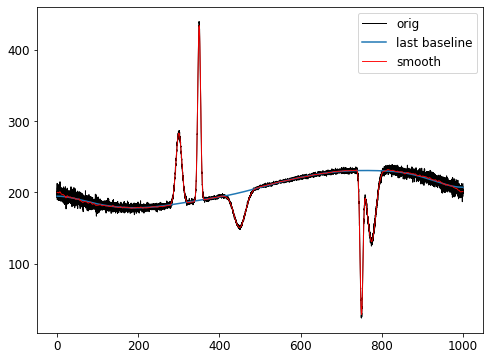

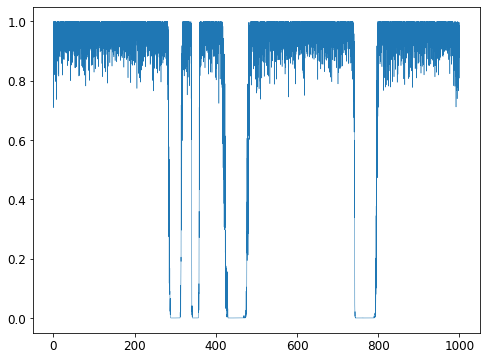

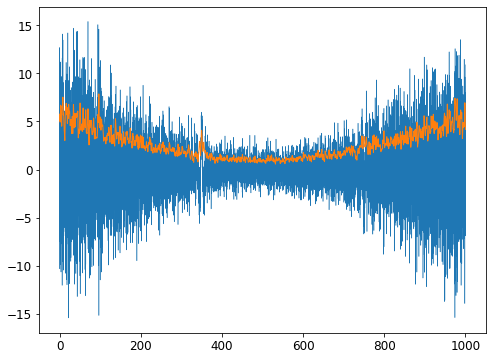

In [376]:

d, zs, ws, dn_vec, std_vec, smoothed = baseline_1D_arPLS(spectra_base, lam=1e-6, smooth_lam=1e-12, niter=50)
# Z, D = baseline_arPLS(spectra_base, lam=1e4, niter=50)

plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'figure.figsize': (8, 6)})

plt.plot(x_vals, spectra_base, label='orig', lw=1, c='k')
plt.plot(x_vals, np.asarray(zs).T[:, -1], label='last baseline')
plt.plot(x_vals, smoothed, label='smooth', c='r', lw=0.9)

plt.legend()
plt.show()
# plt.plot(x_vals, d, label='true data')

plt.plot(x_vals, np.asarray(ws).T[:, -1], lw=0.5, label='weights')
plt.legend
plt.show()

diff = spectra_base - smoothed

kernel = Gaussian1DKernel(1 / tdiff)
diff_blur = convolve_fft(diff ** 2, kernel)

plt.plot(x_vals, diff , lw=0.5)
plt.plot(x_vals, np.sqrt(diff_blur), lw=1)

plt.show()

# plt.plot(x_vals, np.asarray(std_vec).T[:, -1])
# plt.show()

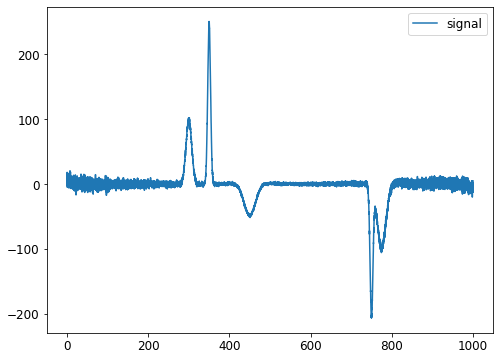

In [377]:
plt.plot(x_vals, d, label='signal')
# plt.plot(x_vals, Z, label='z')
plt.legend()
plt.show()